# Sentiment Analysis with Python
 


In [2]:
!pip install textblob 
!python -m textblob.download_corpora 

     |████████████████████████████████| 645kB 416kB/s eta 0:00:01
[nltk_data] Downloading package brown to /home/tomas/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /home/tomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tomas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/tomas/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/tomas/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [3]:
from textblob import TextBlob, Word, Blobber

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import sqlite3
conn = sqlite3.connect('../data/BoxOffice.db')

In [6]:
df = pd.read_sql("""SELECT a.* FROM movie_overview a
                    INNER JOIN movie_languages b
                    ON a.id = b.movie_id
                    WHERE iso_639_1='en' and sw_original_lang=1
                    AND id NOT IN (80)""",conn)

In [7]:
df.shape

(6201, 2)

In [8]:
df.head()

,id,overview
0,1,"When Lou, who has become the ""father of the In..."
1,2,Mia Thermopolis is now a college graduate and ...
2,3,"Under the direction of a ruthless instructor, ..."
3,6,"Pinocchio and his friends, a glow worm and a m..."
4,7,A young girl buys an antique box at a yard sal...


## Retrieving the sentiment of a text
 
For analyzing sentiments linguistic experts have build a dictionary of the most common used words in each language and have given each word a value determining the degree of positiveness, negativeness of neutrality of each word. The total sentiment of a text is calculated by averaging the sentiment of all the words that compose the text. This measure is expressed as the <i>Polarity</i> of the text and can range from -1 for highly negative sentiment to +1 for highly positive sentiment. 
 
Additionally, some words are known to expose the subjectivity of a statement. For example the word <i> think </i> is highly subjective and points to a personal opinion while the word <i> know </i> is pointing to some kind of information and has lower subjectivity. The subjectivity measure ranges from 0 to 1.


In [9]:
text = TextBlob(df.loc[1,'overview'])
print (text)
text.sentiment

Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-saddle, archery, and other royal. But her complicated life is turned upside down once again when she not only learns that she is to take the crown as queen earlier than expected...


Sentiment(polarity=0.01706349206349206, subjectivity=0.551984126984127)

In [10]:
text = TextBlob(df.loc[3,'overview'])
print (text)
text.sentiment

Pinocchio and his friends, a glow worm and a marionette, search for a magic music box. However, so are the evil Scalawag and the Emperor of the Night.


Sentiment(polarity=-0.25, subjectivity=1.0)

In [11]:
text = TextBlob(df.loc[10,'overview'])
print (text)
text.sentiment

Lester Burnham, a depressed suburban father in a mid-life crisis, decides to turn his hectic life around after developing an infatuation with his daughter's attractive friend.


Sentiment(polarity=0.4, subjectivity=0.5)

In [22]:
### horror movie
text = TextBlob(df.loc[29,'overview'])
print (text)
text.sentiment

After an attempted assassination on Ambassador Han, Inspector Lee and Detective Carter are back in action as they head to Paris to protect a French woman with knowledge of the Triads' secret leaders. Lee also holds secret meetings with a United Nations authority, but his personal struggles with a Chinese criminal mastermind named Kenji, which reveals that it's Lee's long-lost...brother.


Sentiment(polarity=-0.1375, subjectivity=0.29375)

In [26]:
print(text.sentiment[0],text.sentiment[1])

-0.1375 0.29375


## Calculating the sentiment of each movie overview 

In [56]:
n = df.shape[0]
dfsent = {}

for i in range(0,n):
    movie = df.loc[i,'id']
    ### Preprocessing
    text = df.loc[i,'overview']
    ### skip movies with empty overview
    if text != None:
        text = TextBlob(text)
        ### tokenizing
        dfsent[movie] = [text.sentiment[0],text.sentiment[1]]



In [57]:
dfsent = pd.DataFrame(dfsent).transpose()
dfsent.columns = ['polarity','subjectivity']

In [58]:
dfsent.head()

,polarity,subjectivity
1,-0.100000,0.600000
2,0.017063,0.551984
3,-0.066667,0.766667
6,-0.250000,1.000000
7,-0.133333,0.566667


In [66]:
#dfsent['sentiment'] = [1 if dfsent.polarity > 0 else -1 if dfsent.polarity < 0 else 0]
dfsent['sentiment'] = 0
dfsent.loc[dfsent.polarity<0,'sentiment'] = -1
dfsent.loc[dfsent.polarity>0,'sentiment'] = 1
dfsent['sentiment'] = dfsent['sentiment'].astype('category')

In [67]:
dfsent.head()

,polarity,subjectivity,sentiment
1,-0.100000,0.600000,-1
2,0.017063,0.551984,1
3,-0.066667,0.766667,-1
6,-0.250000,1.000000,-1
7,-0.133333,0.566667,-1


In [68]:
dfsent.dtypes

polarity         float64
subjectivity     float64
sentiment       category
dtype: object

In [87]:
[dfsent.groupby('sentiment').count()]

[           polarity  subjectivity
 sentiment                        
 -1             2175          2175
  0              586           586
  1             3439          3439]

In [92]:
dfsent.groupby('sentiment').count()['polarity']


sentiment
-1    2175
 0     586
 1    3439
Name: polarity, dtype: int64

## Analyzing the sentiment by genre

In [94]:
### get movie 
genres = pd.read_sql("""SELECT DISTINCT a.movie_id, b.name 
                        FROM movies_genres a
                        INNER JOIN genres_dim b
                        ON a.id = b.id""",conn)

In [95]:
dfsent['movie_id'] = dfsent.index

In [96]:
movie_groups = pd.merge(dfsent, genres, on='movie_id', how='inner')
movie_groups.head()

,polarity,subjectivity,sentiment,movie_id,name
0,-0.100000,0.600000,-1,1,Comedy
1,0.017063,0.551984,1,2,Comedy
2,0.017063,0.551984,1,2,Drama
3,0.017063,0.551984,1,2,Family
4,0.017063,0.551984,1,2,Romance


In [99]:
movie_groups.groupby('name').mean()['polarity']

name
Action            -0.004867
Adventure          0.030997
Animation          0.069134
Comedy             0.080348
Crime              0.002753
Documentary        0.093015
Drama              0.058996
Family             0.080182
Fantasy            0.053205
Foreign            0.112696
History            0.063770
Horror            -0.050867
Music              0.122750
Mystery           -0.012202
Romance            0.123297
Science Fiction    0.002646
TV Movie           0.136364
Thriller          -0.013710
War               -0.002092
Western            0.008298
Name: polarity, dtype: float64

In [100]:
movie_groups.groupby('name').mean()['subjectivity']

name
Action             0.454523
Adventure          0.482897
Animation          0.499322
Comedy             0.462851
Crime              0.452119
Documentary        0.404022
Drama              0.455705
Family             0.494218
Fantasy            0.511894
Foreign            0.426442
History            0.396055
Horror             0.476052
Music              0.434175
Mystery            0.462130
Romance            0.470757
Science Fiction    0.499297
TV Movie           0.454545
Thriller           0.454029
War                0.368474
Western            0.428055
Name: subjectivity, dtype: float64

In [102]:
sent1 = movie_groups.groupby('name').mean()['polarity']

In [107]:
print(sent1.index)
print(sent1)

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'Western'],
      dtype='object', name='name')
name
Action            -0.004867
Adventure          0.030997
Animation          0.069134
Comedy             0.080348
Crime              0.002753
Documentary        0.093015
Drama              0.058996
Family             0.080182
Fantasy            0.053205
Foreign            0.112696
History            0.063770
Horror            -0.050867
Music              0.122750
Mystery           -0.012202
Romance            0.123297
Science Fiction    0.002646
TV Movie           0.136364
Thriller          -0.013710
War               -0.002092
Western            0.008298
Name: polarity, dtype: float64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

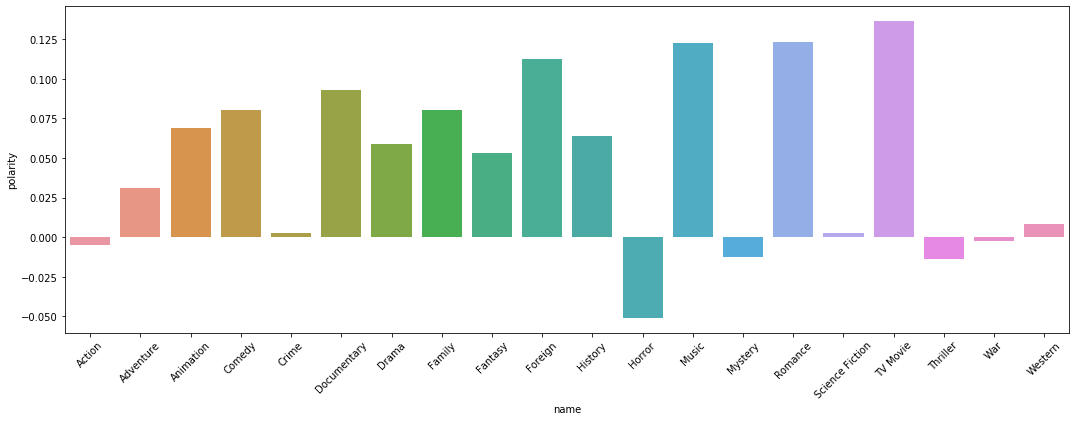

In [114]:
plt.figure(figsize=(18, 6))
g = sns.barplot(x=sent1.index, y=sent1)
plt.xticks(rotation=45)